## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)

#### Part I - Probability

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
number_row = df.shape[0]

In [4]:
number_row

294478

c. The number of unique users in the dataset.

In [5]:
number_unique_users = df.user_id.nunique()

d. The proportion of users converted.

In [6]:
converted_user = df.converted.mean()

e. The number of times the `new_page` and `treatment` don't match.

In [7]:
df.query('group == "treatment" and landing_page =="old_page"').user_id.count()+\
df.query('landing_page == "new_page" and group == "control"').user_id.count()


3893

f. Do any of the rows have missing values?

In [8]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [9]:
# first, drop off the rows where treatment does not match with new_page.
# I name this new dataframe as df1
df1 = df.drop(df.query('group == "treatment" and landing_page =="old_page"').index)

# second, drop off the rows where control does not match with old_page
# I store the clean dataframe in df2
df2 = df1.drop(df.query('landing_page == "new_page" and group == "control"').index)
df2.query('landing_page == "new_page" and group == "control"').index

Int64Index([], dtype='int64')

In [10]:
# check all of the rows in df2 do not contain any mismatches.
df2.query('group == "treatment" and landing_page =="old_page"').index

Int64Index([], dtype='int64')

In [11]:
# check all of the rows in df2 do not contain any mismatches.
df2.query('landing_page == "new_page" and group == "control"').index

Int64Index([], dtype='int64')

In [12]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

a. How many unique **user_id**s are in **df2**?

In [13]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [14]:
sum(df2.user_id.duplicated())

1

c. What is the row information for the repeat **user_id**? 

In [15]:
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [16]:
df2.user_id.drop_duplicates(inplace=True)

In [17]:
sum(df2.user_id.duplicated())

0

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [18]:
df2.converted.mean()

0.11959667567149027

b. Given that an individual was in the `control` group, what is the probability they converted?

In [19]:
df2.query('group == "control"').converted.mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [20]:
df2.query('group == "treatment"').converted.mean()

0.11880724790277405

d. What is the probability that an individual received the new page?

In [21]:
df2.query('landing_page =="new_page"').shape[0]/df2.shape[0]

0.5000636646764286

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**Answer**:
The data shows that the `treatment` group does not display an increase of the conversion rate as compared `control`. The users viewed the new page exhibit 50% of conversion rate which is almost identical to `control`.

<a id='ab_test'></a>
### Part II - A/B Test


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Answer**:

__H0__: **$p_{old}$** >= **$p_{new}$**

__H1__: **$p_{old}$** < **$p_{new}$**

The type I error (false positive) rate is 0.05 ($\alpha$ =5%). if our p value is less than the type I error 0.05, we reject the **null** (H0), that is, we choose the **alternative hypothesis** (H1), which we assume the new page is better than the older page. 

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [22]:
df_2 = pd.read_csv('ab_data.csv')
df_2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [23]:
# our null hypothesis is P_new = p_old
p_new = df_2.converted.mean()
p_new

0.11965919355605512

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [24]:
p_old = df_2.converted.mean()
p_old

0.11965919355605512

c. What is $n_{new}$, the number of individuals in the treatment group?

In [25]:
n_new = df_2[df_2['group'] == "treatment"].query('landing_page == "new_page"').user_id.nunique()
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [26]:
n_old = df_2[df_2['group'] == "control"].query('landing_page == "old_page"').user_id.nunique()
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [27]:
new_page_converted = np.random.binomial(1, p_new, n_new)
new_page_converted.mean()

0.11855343747849426

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [28]:
old_page_converted = np.random.binomial(1, p_old, n_old)
old_page_converted.mean()

0.11980120324352603

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [29]:
new_page_converted.mean() - old_page_converted.mean()

-0.0012477657650317719

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [30]:
p_diffs = []
for _ in range(10000):
    old_page_converted = np.random.binomial(1, p_old, n_old)
    new_page_converted = np.random.binomial(1, p_new, n_new)
    p_diffs.append(new_page_converted.mean()-old_page_converted.mean())
    

In [31]:
p_diffs[-10:]

[0.00041074886549637146,
 -2.400216210077244e-06,
 0.00032806618262609666,
 0.00025249897453381853,
 0.0001285423124185725,
 -0.0014128309853174564,
 -0.0019019156354471572,
 -0.0006490150903594033,
 0.00045200408565042316,
 9.4319003819273717e-05]

In [32]:
# use numpy to calculate the mean of p_diffs generated from binomial simulation
np.mean(p_diffs)

-3.149483479753029e-05

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

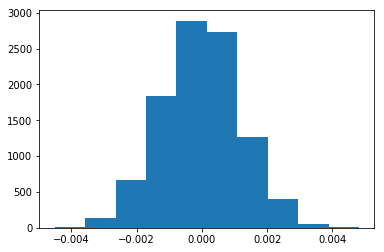

In [33]:
plt.hist(p_diffs);

that's what we expected. The plot exhibts a "bell" normal curve form with a **normal** distrubtion.

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [34]:
df_2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [35]:
# determine the actual difference on converted rates
actual_diffs = df_2[df_2['group'] == "treatment"].converted.mean() -\
df_2[df_2['group'] == "control"].converted.mean()
actual_diffs

-0.0014795997940775518

In [36]:
# count total number of data points with a value greater than the actual difference
num_greater = 0
for i in p_diffs:
    if i > actual_diffs:
        num_greater = num_greater + 1
        
num_greater

8830

In [37]:
# proportion of the p_diffs are greater than the actual difference observed 
P_vals = num_greater/len(p_diffs)
P_vals

0.883

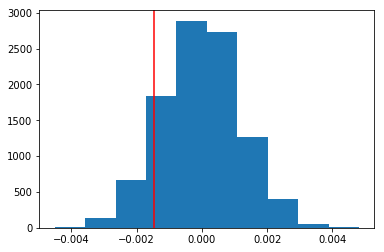

In [38]:
# plot a histogram on the p_diffs
plt.hist(p_diffs)
plt.axvline(x=actual_diffs, color='red');

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Answer**:
We calculated p value equal to about 0.9, which is largly bigger than type I error rate (0.05). Thus, we fail to reject the null hypothesis. we conclude that the new page does not increase sigificantly the converted rate as compared to the old page.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [39]:
df_2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [40]:
import statsmodels.api as sm

convert_old = df_2.query('group == "control"and converted == 1').user_id.count()
convert_new = df_2.query('group == "treatment" and converted == 1').user_id.count()
n_old = df_2[df_2['group'] == "control"].user_id.count()
n_new = df_2[df_2['group'] == "treatment"].user_id.count()

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [41]:
convert_old, convert_new, n_old, n_new

(17723, 17514, 147202, 147276)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [42]:
z_score, p_val = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')
print(z_score, p_val)

-1.23692175473 0.891941933651


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Answer**:
- A z-score is the number of standard deviations from the mean a data point is. Here,  the z-score is -1.23 suggesting that the standard deviation below the mean of conversion rate from this dataset. 
- The p-value is 0.89 suggestion that we fail to reject the null hypothesis, which means the users landed in the old_page have a similar or even better conversion than the users for the new_page.


<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Answer**: We should use logistic regression because the y variable (conversion) takes only two values (0 or 1) like a flip of a coin where the probability of getting “heads” depends on the X-variables.

In [43]:
df2_ab_page =  pd.get_dummies(df2['group']) # create a dummy variable from group
df2_new = df2.join(df2_ab_page, how ='left') # merge two dummy variable columns to df2_new dataset
df2_new = df2_new.dropna()
df2_new.head()

,user_id,timestamp,group,landing_page,converted,control,treatment
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


In [44]:
# add the intercept column
df2_new['intercept'] = 1
df2_new.head()

,user_id,timestamp,group,landing_page,converted,control,treatment,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [45]:
log_mod = sm.Logit(df2_new['converted'], df2_new[['intercept','treatment']])
log_mod_results = log_mod.fit()
log_mod_results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290585
Model:                          Logit   Df Residuals:                   290583
Method:                           MLE   Df Model:                            1
Date:                Mon, 07 Oct 2019   Pseudo R-squ.:               8.085e-06
Time:                        17:31:38   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1897
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
treatment     -0.0150      0.011     -1.312      0.190      -0.037       0.007
==============================================================================
"""

In [46]:
# Calculates the exponential of all parameters in the output summary results in order to interpret them.
np.exp(log_mod_results.params)

intercept    0.136863
treatment    0.985115
dtype: float64

In [47]:
# to better interpret the negative value
1/np.exp(-0.0150)

1.0151130646157189

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

**Answer**:
From our logistic regression model, the coefficient value for `ab_page (treatment)` is negative meaning that the y variable (response,  conversion rate) is negatively correlated to the x variable (the changes of treatment). We can interpret this as follows: For each unit decrease in `ab_page` —we expect the converted rate to increase by almost 1.015 times (50%), holding everything else constant.

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>

**Answer**:
- The p-value generated from the logistic regression model  is 0.1897, and p-value in Part II is ~ 0.9. 
- The difference on the p values between Part I and Part II is because the hypotheses in Part II is a one tail test. 
- In Part II, we tested our hypothesis whether the users landed on the new_page show better conversion rate compared to the old_page. However, we didn’t test the possibility if the users landed on the new_page show worsen conversion rate compared to the old_page. 
- In part III, we used the logistic regression model to our data, this model checked both positive and negative correlation between conversion rate and x variable (`landing_page`), which is a two-tailed test.


f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Answer**: 
- We can consider whether the spent time on the website is correlated with the converted rates. If the users stay longer on the website, whether those users are more likely to be converted.
- The more variables we added, the more likely we observe significant differences just by chance. Moreover, with more variables, our model includes multiple variables that are correlated not just to the response variable (conversion rates), but also to each other. 


g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [48]:
df_countries = pd.read_csv('countries.csv')
df_countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [49]:
df2_new2 = df2_new.join(df_countries.set_index('user_id'), on='user_id', how ='left')
df2_new2.head()

,user_id,timestamp,group,landing_page,converted,control,treatment,intercept,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,US


In [50]:
df2_country =  pd.get_dummies(df2_new2['country'])
df2_new2 = df2_new2.join(df2_country, how ='left')
df2_new2.head()

,user_id,timestamp,group,landing_page,converted,control,treatment,intercept,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,0,1,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,0,1,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,US,0,0,1


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [51]:
log_new = sm.Logit(df2_new2['converted'], df2_new2[['intercept','treatment','UK','US']])
log_new_results = log_new.fit()
log_new_results.summary()

Optimization terminated successfully.
         Current function value: 0.366112
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290585
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            3
Date:                Mon, 07 Oct 2019   Pseudo R-squ.:               2.324e-05
Time:                        17:31:39   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1758
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
treatment     -0.0150      0.011     -1.308      0.191      -0.037       0.007
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
US             0.0408      0.027      1.516      0.130      -0.012       0.093
==============================================================================
"""

In [52]:
#"Calculates the exponential of all parameters in the output summary results
np.exp(log_new_results.params)

intercept    0.131332
treatment    0.985160
UK           1.051944
US           1.041593
dtype: float64

In [53]:
# to better interpret the negative parameter
1/np.exp(-0.0150)

1.0151130646157189

**Summary**:
- Based on the new result presented above, it seems that there is a positive correlation between the conversion rate and the countries where the users live, the users from the UK are more likely to be converted as compared to US.. However, none of the p-value from both variables are statistical significance (less than 0.05).
- The users from the US, the conversion is very similar to the UK with 1.04 times higher than CA, holding everything else constant.
- The coefficient value for `treatment` is negative meaning that the y variable (response,  conversion rate) is negatively correlated to the x variable (the changes of treatment). We can interpret this as follows: For each unit decrease in `treatment` —we expect the converted rate to increase by almost 1.015 times (50%), holding everything else constant.
- The users from the UK, the conversion rate is 100% (1.052 times) higher than CA, holding everything else constant.


In [54]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0